#### This notebook calculates tissue area across different registration methods, including rigid registration, and rigid-then-elas registration, based on our optimal transport result.

In [52]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
sys.path.append('E:/REGISTRATION_SOFTWARE/algorithm/cell_level_regist/paper/code/result_analysis')

from img_based_analysis import gen_binset_img, calculate_ssim, calculate_ty_area

In [53]:
def gen_area_df_dif_z(all_data_output, mark_data, mtd, pixel_size, regis, output_img_dir, ctype_col='annotation'):
    """
    generate dataframe of area, in the same unit as of spatial information 
    """
    regis_scores = {}
    
    print(regis)
    fo = [fo for fo in os.listdir(all_data_output) if mark_data in fo and mtd in fo][0]
    dir = os.path.join(all_data_output, fo)
    fname_int_li = [int(fname.replace('.h5ad', '')) for fname in os.listdir(dir) if fname.endswith('.h5ad')]
    fname_int_li.sort()
    fname_li = [str(fname_int) + '.h5ad' for fname_int in fname_int_li]
    dir_li = [os.path.join(dir, fname) for fname in fname_li]

    arr_img_li, arr_ctype_li, ty_li, z_li = gen_binset_img(dir_li, pixel_size= pixel_size, output_img_dir=output_img_dir, spa_col=regis, ctype_col=ctype_col)  # fixme
    print(z_li)
    area_df = calculate_ty_area(arr_ctype_li, ty_li)
    area_df = area_df * pixel_size ** 2
    # add 'z' to the first
    # area_df.set_axis(ty_li, axis='index')
    col_li = area_df.columns.tolist()
    area_df['z'] = z_li
    area_df = area_df[['z'] + col_li]
    return area_df

In [54]:
# todo: apply.func causes inf value
def scale_inde_std_dif_old(df): 
    def std_over_mean_each_col(col):
        return np.std(col) / (abs(col.mean()) + 0.001)

    col_li = list(df.columns)
    col_li.remove('z')

    df_dif = df[col_li].iloc[1:].reset_index(drop=True) - df[col_li].iloc[:-1].reset_index(drop=True)
    print(np.std(df_dif['CNS']), abs(df_dif['CNS'].mean()) + 0.001, np.std(df_dif['CNS'])/(abs(df_dif['CNS'].mean()) + 0.001))
    si_std_d = df_dif.apply(std_over_mean, axis=0)  # scale-independent standard deviation of differences
    print(si_std_d['CNS'])
    return si_std_d

In [55]:
def scale_inde_std_dif(df): 
    col_li = list(df.columns)
    col_li.remove('z')
    
    df_dif = df[col_li].iloc[1:].reset_index(drop=True) - df[col_li].iloc[:-1].reset_index(drop=True)
    std_over_mean_all_ty = {}
    for col in df_dif.columns:
        std_over_mean = np.std(df_dif[col]) / (abs(df_dif[col].mean()) + 0.001)  # scale-independent standard deviation of differences
        std_over_mean_all_ty[col] = std_over_mean 
    # print(std_over_mean_all_ty)
    si_std_d = pd.Series(std_over_mean_all_ty)
    return si_std_d

In [56]:
def sum_of_ctypes(df):
    col_li = list(df.columns)
    col_li.remove('z')
    return df[col_li].sum()

##### tissue area among rigid and elastic registration, of drosophila embryo and drosophila larva

result of all cell types using rigid and elastic registration, respectively

In [81]:
all_data_output = 'E:/REGISTRATION_SOFTWARE/algorithm/cell_level_regist/paper/output_data/our_pipeline'
mark_data = 'drosophila_embryo'
mtd = 'ours'
output_img_dir = None
# recommended pixel_size: math.sqrt(2) * binset_size todo: 写入函数
# fruitfly_embryo: pixel_size=1
# fruitfly_larva: pixel_size=3.5
# DLPFC: pixel_size=213
pixel_size = 1
df_droso_embryo_rigid = gen_area_df_dif_z(all_data_output, mark_data, mtd, pixel_size, 'spatial_rigid', output_img_dir)
df_droso_embryo_elas = gen_area_df_dif_z(all_data_output, mark_data, mtd, pixel_size, 'spatial_elas', output_img_dir)



spatial_rigid
0 / 15
1 / 15
2 / 15
3 / 15
4 / 15
5 / 15
6 / 15
7 / 15
8 / 15
9 / 15
10 / 15
11 / 15
12 / 15
13 / 15
14 / 15
15 / 15
[0.0, 0.7, 1.4, 2.0999999999999996, 2.8, 3.5, 4.199999999999999, 4.8999999999999995, 5.6, 6.3, 7.0, 7.699999999999999, 8.399999999999999, 9.1, 9.799999999999999, 10.5]
spatial_elas
0 / 15
1 / 15
2 / 15
3 / 15
4 / 15
5 / 15
6 / 15
7 / 15
8 / 15
9 / 15
10 / 15
11 / 15
12 / 15
13 / 15
14 / 15
15 / 15
[0.0, 0.7, 1.4, 2.0999999999999996, 2.8, 3.5, 4.199999999999999, 4.8999999999999995, 5.6, 6.3, 7.0, 7.699999999999999, 8.399999999999999, 9.1, 9.799999999999999, 10.5]


Text(0, 0.5, 'Area (100 µm $^2$)')

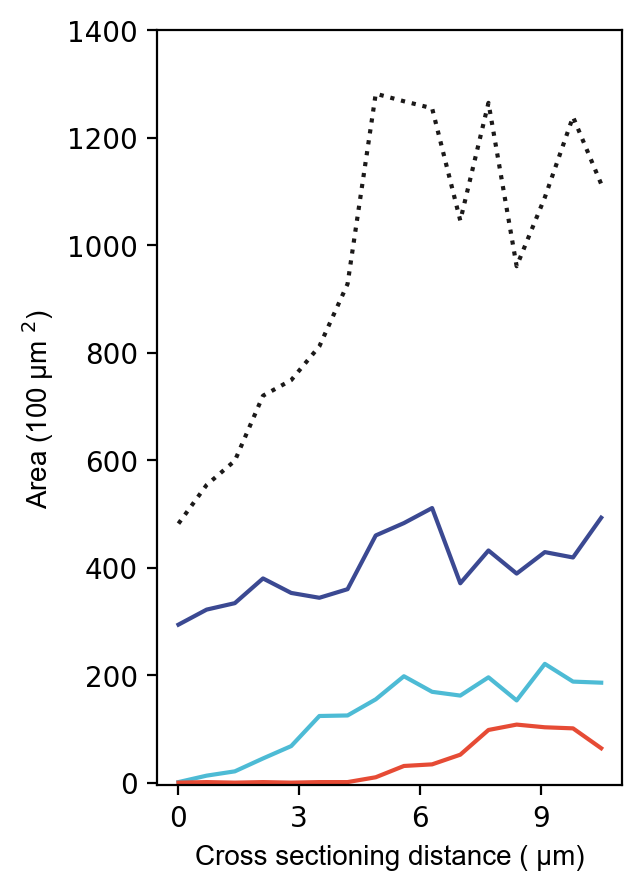

In [83]:
ty2co = {'all': '#1B1919FF', 'epidermis':'#3B4992FF', 'midgut':'#4DBBD5FF', 'foregut':'#E64B35FF'}#808180FF
df = df_droso_embryo_rigid

plt.figure(figsize=(3,5), dpi=200)  # (2.5, 5)
for col in ['all', 'epidermis', 'midgut', 'foregut']:
    if col == 'all':
        plt.plot(df['z'], df[col], color=ty2co[col], label=col, ls=':')
    else:
        plt.plot(df['z'], df[col], color=ty2co[col], label=col)

plt.ylim(-5, 1400)    
plt.xticks(np.arange(0, df['z'].max()+0.1, 3))

# plt.tick_params(labelleft=False)

# plt.legend(ncol=1, loc='center right')

plt.xlabel('Cross sectioning distance ( µm)', fontname='Arial')
plt.ylabel('Area (100 µm {})'.format('$^2$'), fontname='Arial')

In [ ]:
out_dir  = 'E:/REGISTRATION_SOFTWARE/algorithm/cell_level_regist/paper/result_analysis/tissue_area'  # change this to your directory to save the csv file, in order to reproduce figure in the paper
df_droso_embryo_rigid.to_csv(os.path.join(out_dir, 'drosophila_embryo_rigid.csv'), index=False)
df_droso_embryo_elas.to_csv(os.path.join(out_dir, 'drosophila_embryo_elas.csv'), index=False)

In [20]:
# calculate scale-independent std difference
si_std_d_rigid = scale_inde_std_dif(df_droso_embryo_rigid)
si_std_d_elas = scale_inde_std_dif(df_droso_embryo_elas)
print('rigid\n', si_std_d_rigid, '\n\n','elas\n',  si_std_d_elas)

# calculate and rank average area
droso_embryo_rigid_area = sum_of_ctypes(df_droso_embryo_rigid)
droso_embryo_elas_area = sum_of_ctypes(df_droso_embryo_elas)
droso_embryo_area_avg = droso_embryo_rigid_area.add(droso_embryo_elas_area) / 2
print('\ncell types with the most area\n', droso_embryo_area_avg.nlargest(n=5))

rigid
 CNS                  34.323988
epidermis             4.134161
carcass           98363.272278
trachea               6.646709
muscle               12.422708
midgut                2.523257
fat body              9.849930
amnioserosa          10.852908
foregut               3.921361
salivary gland        9.296278
all                   3.766277
dtype: float64 

 elas
 CNS               389.859076
epidermis           3.273551
carcass           930.079527
trachea             5.617130
muscle             49.128237
midgut              2.098910
fat body           10.460815
amnioserosa        11.325085
foregut             2.962731
salivary gland     10.420445
all                 1.932558
dtype: float64

cell types with the most area
 all          15137.5
epidermis     6362.0
midgut        1997.5
CNS           1462.5
trachea       1328.5
dtype: float64


on drosophila larva

In [6]:
all_data_output = 'E:/REGISTRATION_SOFTWARE/algorithm/cell_level_regist/paper/output_data/our_pipeline'
mark_data = 'drosophila_larva'  # 'drosophila_embryo'
mtd = 'ours'
output_img_dir = None
# recommended pixel_size: math.sqrt(2) * binset_size todo: 写入函数
# fruitfly_embryo: pixel_size=1
# fruitfly_larva: pixel_size=3.5
# DLPFC: pixel_size=213
pixel_size = 3.5
df_droso_larva_rigid = gen_area_df_dif_z(all_data_output, mark_data, mtd, pixel_size, 'spatial_rigid', output_img_dir)
df_droso_larva_elas = gen_area_df_dif_z(all_data_output, mark_data, mtd, pixel_size, 'spatial_elas', output_img_dir)

# fix z
df_droso_larva_rigid['z'] = df_droso_larva_rigid.index * 1
df_droso_larva_elas['z'] = df_droso_larva_elas.index * 1
print(df_droso_larva_rigid['z'], df_droso_larva_elas['z'])
# df_droso_larva_rigid[['z']] = df_droso_larva_rigid[['z']] - 0.7
# df_droso_larva_elas[['z']] = df_droso_larva_elas[['z']] - 0.7

spatial_rigid
0 / 15
1 / 15
2 / 15
3 / 15
4 / 15
5 / 15
6 / 15
7 / 15
8 / 15
9 / 15
10 / 15
11 / 15
12 / 15
13 / 15
14 / 15
15 / 15
[0.7, 1.4, 2.0999999999999996, 2.8, 3.5, 4.199999999999999, 4.8999999999999995, 5.6, 6.3, 7.0, 7.699999999999999, 8.399999999999999, 9.1, 9.799999999999999, 10.5, 11.2]
spatial_elas
0 / 15
1 / 15
2 / 15
3 / 15
4 / 15
5 / 15
6 / 15
7 / 15
8 / 15
9 / 15
10 / 15
11 / 15
12 / 15
13 / 15
14 / 15
15 / 15
[0.7, 1.4, 2.0999999999999996, 2.8, 3.5, 4.199999999999999, 4.8999999999999995, 5.6, 6.3, 7.0, 7.699999999999999, 8.399999999999999, 9.1, 9.799999999999999, 10.5, 11.2]
0      0
1      1
2      2
3      3
4      4
5      5
6      6
7      7
8      8
9      9
10    10
11    11
12    12
13    13
14    14
15    15
Name: z, dtype: int64 0      0
1      1
2      2
3      3
4      4
5      5
6      6
7      7
8      8
9      9
10    10
11    11
12    12
13    13
14    14
15    15
Name: z, dtype: int64


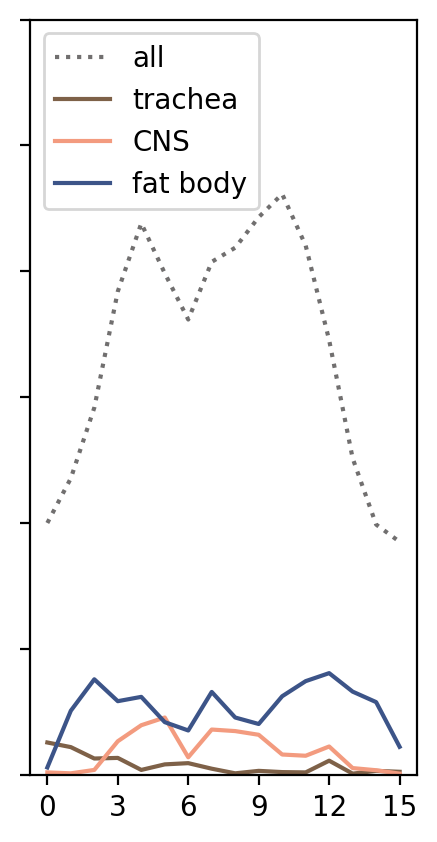

In [93]:

ty2co = {'all': '#1B19199F', 'trachea':'#7E6148FF', 'CNS':'#F39B7FFF', 'fat body':'#3C5488FF'} ##00A087FF '#E64B35FF'
df = df_droso_larva_elas

plt.figure(figsize=(2.5,5), dpi=200)  # (2.5, 5)
for col in ['all', 'trachea', 'CNS', 'fat body']:
    if col == 'all':
        plt.plot(df['z'], df[col], color=ty2co[col], label=col, ls=':')
    else:
        plt.plot(df['z'], df[col], color=ty2co[col], label=col)
plt.ylim(0, 30000)    
plt.xticks(np.arange(0, df['z'].max()+0.1, 3))
plt.legend(ncol=1)
plt.tick_params(labelleft=False)
# plt.xlabel('Cross sectioning distance ( µm)', fontname='Arial')
# plt.ylabel('Area (100 µm {})'.format('$^2$'), fontname='Arial')

In [12]:
# calculate scale-independent std difference
si_std_d_rigid = scale_inde_std_dif(df_droso_larva_rigid)
si_std_d_elas = scale_inde_std_dif(df_droso_larva_elas)
print('rigid\n', si_std_d_rigid, '\n\n','elas\n',  si_std_d_elas)

# calculate and rank average area
droso_larva_rigid_area = sum_of_ctypes(df_droso_larva_rigid)
droso_larva_elas_area = sum_of_ctypes(df_droso_larva_elas)
droso_larva_area_avg = droso_larva_rigid_area.add(droso_larva_elas_area) / 2
print('\ncell types with the most area\n', droso_larva_area_avg.nlargest(n=20))

rigid
 epidermis                         3.961648
trachea                           4.459052
muscle                            3.542523
carcass                          15.826127
fat body/trachea                 56.348742
midgut                           16.769121
CNS                             239.623590
fat body                         22.892126
hindgut                          18.566014
salivary gland               448691.263565
epidermis/CNS                502757.670255
testis                            9.852485
foregut                      501163.255171
foregut/garland cells        301824.355655
midgut/malpighian tubules    221586.213470
all                             154.639779
dtype: float64 

 elas
 epidermis                         4.160746
trachea                           3.358165
muscle                            3.331957
carcass                          14.570073
fat body/trachea                 19.529036
midgut                           16.476437
CNS                    

In [10]:
out_dir  = 'E:/REGISTRATION_SOFTWARE/algorithm/cell_level_regist/paper/result_analysis/tissue_area'  # change this to your directory to save the csv file, in order to reproduce figure in the paper
df_droso_embryo_rigid.to_csv(os.path.join(out_dir, 'drosophila_larva_rigid.csv'), index=False)
df_droso_embryo_elas.to_csv(os.path.join(out_dir, 'drosophila_larva_elas.csv'), index=False)

###### tissue area of mouse embryo among different methods 

result of all cell types using different methods

In [13]:
all_data_output = 'E:/REGISTRATION_SOFTWARE/algorithm/cell_level_regist/paper/output_data/our_pipeline'
mark_data = 'mouse_embryo_E11.5'
output_img_dir = None
# recommended pixel_size: math.sqrt(2) * binset_size todo: 写入函数
# fruitfly_embryo: pixel_size=1
# fruitfly_larva: pixel_size=3.5
# DLPFC: pixel_size=213
# mouse_embryo: pixel_size = 100
pixel_size = 100
df_mouse_embryo_ours = gen_area_df_dif_z(all_data_output, mark_data, 'ours', pixel_size, 'spatial_elas', output_img_dir)  # area unit: bin1 (0.25 μm^2)
df_mouse_embryo_PASTE = gen_area_df_dif_z(all_data_output, mark_data, 'PASTE', pixel_size, 'spatial_rigid', output_img_dir)
df_mouse_embryo_PASTE2 = gen_area_df_dif_z(all_data_output, mark_data, 'PASTE2', pixel_size, 'spatial_rigid', output_img_dir)

#  change the unit from sq bin1(0.25 μm^2) to (100μm^2)
col_li = list(df_mouse_embryo_ours.columns)
col_li.remove('z')

df_mouse_embryo_ours[col_li] =  df_mouse_embryo_ours[col_li] / 400
df_mouse_embryo_PASTE[col_li] =  df_mouse_embryo_PASTE[col_li] / 400
df_mouse_embryo_PASTE2[col_li] =  df_mouse_embryo_PASTE2[col_li] / 400

spatial_elas
0 / 5
1 / 5
2 / 5
3 / 5
4 / 5
5 / 5
[1280.0, 1300.0, 1320.0, 1340.0, 1360.0, 1380.0]
spatial_rigid
0 / 5
1 / 5
2 / 5
3 / 5
4 / 5
5 / 5
[1280.0, 1300.0, 1320.0, 1340.0, 1360.0, 1380.0]
spatial_rigid
0 / 5
1 / 5
2 / 5
3 / 5
4 / 5
5 / 5
[1280.0, 1300.0, 1320.0, 1340.0, 1360.0, 1380.0]


In [22]:
df_mouse_embryo_ours

,z,Surface ectoderm,Mesenchyme,Dermomyotome,Meninges,Head mesenchyme,Hindbrain,Jaw,Branchial arch,Epithelium,Forebrain,Limb,Midbrain,Intermediate mesoderm,all
0,1280.0,5475.0,30650.0,5925.0,12275.0,5175.0,12525.0,6750.0,3225.0,3900.0,10650.0,4225.0,3750.0,0.0,104525.0
1,1300.0,5625.0,27475.0,5775.0,12225.0,4700.0,11950.0,5050.0,2250.0,4575.0,13950.0,4475.0,3025.0,4075.0,105150.0
2,1320.0,5250.0,24250.0,5175.0,10800.0,8925.0,14050.0,3175.0,2725.0,4475.0,12900.0,4100.0,3825.0,4250.0,103900.0
3,1340.0,6725.0,20200.0,6200.0,9825.0,7375.0,15525.0,2975.0,3275.0,4350.0,14350.0,4225.0,3100.0,3075.0,101200.0
4,1360.0,5325.0,14875.0,4375.0,5650.0,7075.0,15825.0,3350.0,2925.0,5675.0,16175.0,4200.0,3225.0,5225.0,93900.0
5,1380.0,6450.0,17750.0,2400.0,6275.0,6775.0,19500.0,7750.0,0.0,3050.0,15375.0,4550.0,1700.0,1700.0,93275.0


In [19]:
out_dir  = 'E:/REGISTRATION_SOFTWARE/algorithm/cell_level_regist/paper/result_analysis/tissue_area'  # change this to your directory to save the csv file, in order to reproduce figure in the paper
df_mouse_embryo_ours.to_csv(os.path.join(out_dir, 'mouse_embryo_E11.5_ours_elas.csv'), index=False)
df_mouse_embryo_PASTE.to_csv(os.path.join(out_dir, 'mouse_embryo_E11.5_PASTE_rigid.csv'), index=False)
df_mouse_embryo_PASTE2.to_csv(os.path.join(out_dir, 'mouse_embryo_E11.5_PASTE2_rigid.csv'), index=False)

results of different methods on each cell type

In [29]:
# calculate and save area data
save_dir = 'E:/REGISTRATION_SOFTWARE/algorithm/cell_level_regist/paper/result_analysis/tissue_area'
col_li = list(df_mouse_embryo_PASTE.columns)
col_li.remove('z')

for col in col_li:    
    df_sin_mtd = df_mouse_embryo_PASTE[['z']]
    area_sum = 0
    for df, mtd in zip([df_mouse_embryo_PASTE, df_mouse_embryo_PASTE2, df_mouse_embryo_ours], ['PASTE', 'PASTE2', 'ours']):
        df_sin_mtd[mtd] = df[col]
    df_sin_mtd.to_csv(os.path.join(save_dir, 'mouse_embryo_E11.5_{}.csv'.format(col)), index=False)

C:\Users\xiatianyi\AppData\Local\Temp\ipykernel_10460\2331619066.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sin_mtd[mtd] = df[col]
C:\Users\xiatianyi\AppData\Local\Temp\ipykernel_10460\2331619066.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sin_mtd[mtd] = df[col]
C:\Users\xiatianyi\AppData\Local\Temp\ipykernel_10460\2331619066.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See

In [24]:
# calculate scale-independent std difference
si_std_d_ours = scale_inde_std_dif(df_mouse_embryo_ours)
si_std_d_PASTE = scale_inde_std_dif(df_mouse_embryo_PASTE)
si_std_d_PASTE2 = scale_inde_std_dif(df_mouse_embryo_PASTE2)
print('ours\n', si_std_d_ours, '\n\nPASTE\n',  si_std_d_PASTE, '\n\nPASTE2\n', si_std_d_PASTE2)

# calculate and rank average area
sum_area_ours = sum_of_ctypes(df_mouse_embryo_ours)
sum_area_PASTE = sum_of_ctypes(df_mouse_embryo_PASTE)
sum_area_PASTE2 = sum_of_ctypes(df_mouse_embryo_PASTE2)

avg_area = sum_area_ours.add(sum_area_PASTE).add(sum_area_PASTE2) / 3
print('\ncell types with the most area\n', avg_area.nlargest(n=6))

ours
 Surface ectoderm          5.316638
Mesenchyme                1.099341
Dermomyotome              1.576860
Meninges                  1.374620
Head mesenchyme           6.272868
Hindbrain                 1.052653
Jaw                      11.345923
Branchial arch            1.970484
Epithelium                7.884501
Forebrain                 1.745260
Limb                      3.896532
Midbrain                  1.948774
Intermediate mesoderm     7.724360
all                       1.218965
dtype: float64 

PASTE
 Surface ectoderm          24.873713
Mesenchyme                 1.559110
Dermomyotome               1.778041
Meninges                   0.958855
Head mesenchyme            9.917025
Hindbrain                  1.109551
Jaw                      514.206404
Branchial arch             1.696732
Epithelium                 6.401035
Forebrain                  1.213028
Limb                       3.839696
Midbrain                   5.104804
Intermediate mesoderm      9.518273
all         

###### tissue area of abrabidopsis leaves among different methods 

result of all cell types using different methods

In [17]:
all_data_output = 'E:/REGISTRATION_SOFTWARE/algorithm/cell_level_regist/paper/output_data/our_pipeline'
mark_data = 'abra_leaves'
output_img_dir = None
# recommended pixel_size: math.sqrt(2) * binset_size todo: 写入函数
# fruitfly_embryo: pixel_size=1
# fruitfly_larva: pixel_size=3.5
# DLPFC: pixel_size=213
# mouse_embryo: pixel_size = 100
pixel_size = 50
df_abra_leaves_ours = gen_area_df_dif_z(all_data_output, mark_data, 'ours', pixel_size, 'spatial_elas', output_img_dir, ctype_col='cell_type')  # area unit: bin1 (0.25 μm^2)
df_abra_leaves_PASTE = gen_area_df_dif_z(all_data_output, mark_data, 'PASTE', pixel_size, 'spatial_rigid', output_img_dir, ctype_col='cell_type')
df_abra_leaves_PASTE2 = gen_area_df_dif_z(all_data_output, mark_data, 'PASTE2', pixel_size, 'spatial_rigid', output_img_dir, ctype_col='cell_type')

#  change the unit from sq bin1(0.25 μm^2) to (100μm^2)
col_li = list(df_abra_leaves_ours.columns) 
col_li.remove('z')

df_abra_leaves_ours[['z']] =  df_abra_leaves_ours[['z']] * 0.5    # bin1 to μm
df_abra_leaves_PASTE[['z']] =  df_abra_leaves_PASTE[['z']] * 0.5
df_abra_leaves_PASTE2[['z']] =  df_abra_leaves_PASTE2[['z']] * 0.5

df_abra_leaves_ours[col_li] =  df_abra_leaves_ours[col_li] / 400  
df_abra_leaves_PASTE[col_li] =  df_abra_leaves_PASTE[col_li] / 400
df_abra_leaves_PASTE2[col_li] =  df_abra_leaves_PASTE2[col_li] / 400

spatial_elas
0 / 3
1 / 3
2 / 3
3 / 3
[0.0, 4000.0, 8000.0, 12000.0]
spatial_rigid
0 / 3
1 / 3
2 / 3
3 / 3
[0.0, 4000.0, 8000.0, 12000.0]
spatial_rigid
0 / 3
1 / 3
2 / 3
3 / 3
[0.0, 4000.0, 8000.0, 12000.0]


In [18]:
df_abra_leaves_PASTE2

,z,Guard_cell,Spongy_mesophyll_cell,Upper_epidermal_cell,Palisade_mesophyll_cell,Vascular_cell,Lower_epidermal_cell,all
0,0.0,31.25,1456.25,1387.50,1106.25,318.75,725.00,5025.00
1,2000.0,50.00,2481.25,725.00,1162.50,318.75,675.00,5412.50
2,4000.0,68.75,1675.00,881.25,1768.75,250.00,718.75,5362.50
3,6000.0,81.25,1862.50,706.25,2275.00,237.50,843.75,6006.25


results of different methods on each cell type

In [19]:
# calculate and save area data
save_dir = 'E:/REGISTRATION_SOFTWARE/algorithm/cell_level_regist/paper/result_analysis/tissue_area'
col_li = list(df_abra_leaves_ours.columns)
col_li.remove('z')

for col in col_li:    
    df_sin_mtd = df_abra_leaves_ours[['z']]
    area_sum = 0
    for df, mtd in zip([df_abra_leaves_PASTE, df_abra_leaves_PASTE2, df_abra_leaves_ours], ['PASTE', 'PASTE2', 'ours']):
        df_sin_mtd[mtd] = df[col]
    df_sin_mtd.to_csv(os.path.join(save_dir, 'abra_leaves_{}.csv'.format(col)), index=False)

C:\Users\xiatianyi\AppData\Local\Temp\ipykernel_20280\549231723.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sin_mtd[mtd] = df[col]
C:\Users\xiatianyi\AppData\Local\Temp\ipykernel_20280\549231723.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sin_mtd[mtd] = df[col]
C:\Users\xiatianyi\AppData\Local\Temp\ipykernel_20280\549231723.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See th

In [21]:
# calculate scale-independent std difference
si_std_d_ours = scale_inde_std_dif(df_abra_leaves_ours)
si_std_d_PASTE = scale_inde_std_dif(df_abra_leaves_PASTE)
si_std_d_PASTE2 = scale_inde_std_dif(df_abra_leaves_PASTE2)
print('ours\n', si_std_d_ours, '\n\nPASTE\n',  si_std_d_PASTE, '\n\nPASTE2\n', si_std_d_PASTE2)

# calculate and rank average area
sum_area_ours = sum_of_ctypes(df_abra_leaves_ours)
sum_area_PASTE = sum_of_ctypes(df_abra_leaves_PASTE)
sum_area_PASTE2 = sum_of_ctypes(df_abra_leaves_PASTE2)

avg_area = sum_area_ours.add(sum_area_PASTE).add(sum_area_PASTE2) / 3
print('\ncell types with the most area\n', avg_area.nlargest(n=6))

ours
 Guard_cell                 0.707050
Spongy_mesophyll_cell      9.360203
Upper_epidermal_cell       1.981584
Palisade_mesophyll_cell    0.467869
Vascular_cell              0.915797
Lower_epidermal_cell       1.686241
all                        0.854445
dtype: float64 

PASTE
 Guard_cell                 0.176766
Spongy_mesophyll_cell      7.496365
Upper_epidermal_cell       1.882441
Palisade_mesophyll_cell    0.429528
Vascular_cell              0.883857
Lower_epidermal_cell       1.870679
all                        0.991853
dtype: float64 

PASTE2
 Guard_cell                 0.176766
Spongy_mesophyll_cell      5.527427
Upper_epidermal_cell       1.480842
Palisade_mesophyll_cell    0.614018
Vascular_cell              1.104013
Lower_epidermal_cell       1.806376
all                        0.875695
dtype: float64

cell types with the most area
 all                        21756.25
Spongy_mesophyll_cell       7456.25
Palisade_mesophyll_cell     6187.50
Upper_epidermal_cell        3831.2

###### tissue area of abrabidopsis leaves among different methods 

result of all cell types using different methods

In [57]:
all_data_output = 'E:/REGISTRATION_SOFTWARE/algorithm/cell_level_regist/paper/output_data/our_pipeline'
mark_data = 'drosophila_embryo'
output_img_dir = None
# recommended pixel_size: math.sqrt(2) * binset_size todo: 写入函数
# fruitfly_embryo: pixel_size=1
# fruitfly_larva: pixel_size=3.5
# DLPFC: pixel_size=213
# mouse_embryo: pixel_size = 100
pixel_size = 1
df_droso_embryo_ours = gen_area_df_dif_z(all_data_output, mark_data, 'ours', pixel_size, 'spatial_elas', output_img_dir, ctype_col='annotation')  # area unit: bin1 (0.25 μm^2)
df_droso_embryo_PASTE = gen_area_df_dif_z(all_data_output, mark_data, 'PASTE', pixel_size, 'spatial_rigid', output_img_dir, ctype_col='annotation')
df_droso_embryo_PASTE2 = gen_area_df_dif_z(all_data_output, mark_data, 'PASTE2', pixel_size, 'spatial_rigid', output_img_dir, ctype_col='annotation')


spatial_elas
0 / 15
1 / 15
2 / 15
3 / 15
4 / 15
5 / 15
6 / 15
7 / 15
8 / 15
9 / 15
10 / 15
11 / 15
12 / 15
13 / 15
14 / 15
15 / 15
[0.0, 0.7, 1.4, 2.0999999999999996, 2.8, 3.5, 4.199999999999999, 4.8999999999999995, 5.6, 6.3, 7.0, 7.699999999999999, 8.399999999999999, 9.1, 9.799999999999999, 10.5]
spatial_rigid
0 / 15
1 / 15
2 / 15
3 / 15
4 / 15
5 / 15
6 / 15
7 / 15
8 / 15
9 / 15
10 / 15
11 / 15
12 / 15
13 / 15
14 / 15
15 / 15
[0.0, 0.7, 1.4, 2.0999999999999996, 2.8, 3.5, 4.199999999999999, 4.8999999999999995, 5.6, 6.3, 7.0, 7.699999999999999, 8.399999999999999, 9.1, 9.799999999999999, 10.5]
spatial_rigid
0 / 15
1 / 15
2 / 15
3 / 15
4 / 15
5 / 15
6 / 15
7 / 15
8 / 15
9 / 15
10 / 15
11 / 15
12 / 15
13 / 15
14 / 15
15 / 15
[0.0, 0.7, 1.4, 2.0999999999999996, 2.8, 3.5, 4.199999999999999, 4.8999999999999995, 5.6, 6.3, 7.0, 7.699999999999999, 8.399999999999999, 9.1, 9.799999999999999, 10.5]


Text(0, 0.5, 'Area (100 µm $^2$)')

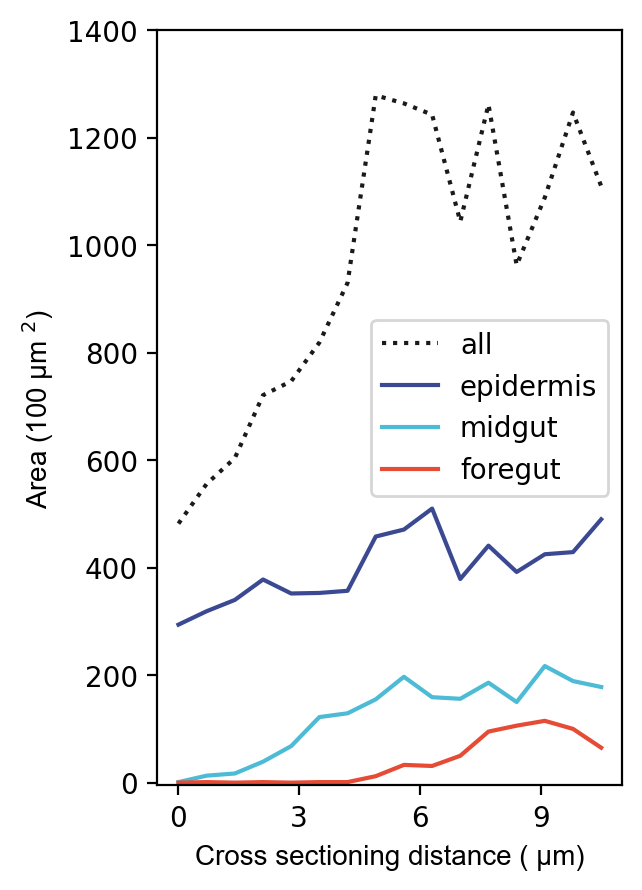

In [79]:
ty2co = {'all': '#1B1919FF', 'epidermis':'#3B4992FF', 'midgut':'#4DBBD5FF', 'foregut':'#E64B35FF'}#808180FF
df = df_droso_embryo_PASTE

plt.figure(figsize=(3,5), dpi=200)  # (2.5, 5)
for col in ['all', 'epidermis', 'midgut', 'foregut']:
    if col == 'all':
        plt.plot(df['z'], df[col], color=ty2co[col], label=col, ls=':')
    else:
        plt.plot(df['z'], df[col], color=ty2co[col], label=col)

plt.ylim(-5, 1400)    
plt.xticks(np.arange(0, df['z'].max()+0.1, 3))

# plt.tick_params(labelleft=False)

plt.legend(ncol=1, loc='center right')

plt.xlabel('Cross sectioning distance ( µm)', fontname='Arial')
plt.ylabel('Area (100 µm {})'.format('$^2$'), fontname='Arial')

In [17]:
out_dir  = 'E:/REGISTRATION_SOFTWARE/algorithm/cell_level_regist/paper/result_analysis/tissue_area'  # change this to your directory to save the csv file, in order to reproduce figure in the paper
df_droso_embryo_PASTE.to_csv(os.path.join(out_dir, 'drosophila_embryo_PASTE.csv'), index=False)
df_droso_embryo_PASTE2.to_csv(os.path.join(out_dir, 'drosophila_embryo_PASTE2.csv'), index=False)

,z,CNS,epidermis,carcass,trachea,muscle,midgut,fat body,amnioserosa,foregut,salivary gland,all
0,0.0,43,294,5,33,106,1,0,0,0,0,482
1,0.7,64,319,4,39,100,13,14,2,1,0,556
2,1.4,73,340,1,19,85,17,31,32,0,6,604
3,2.1,67,378,3,6,72,39,31,52,1,72,721
4,2.8,82,352,0,22,52,68,26,57,0,88,747
5,3.5,87,353,1,15,61,122,23,68,1,88,819
6,4.2,87,357,72,74,42,129,19,47,1,102,930
7,4.9,105,458,221,96,37,155,36,81,12,78,1279
8,5.6,111,471,67,158,38,197,33,88,33,68,1264
9,6.3,162,510,49,127,42,159,50,84,31,29,1243


In [11]:
# calculate and save area data
save_dir = 'E:/REGISTRATION_SOFTWARE/algorithm/cell_level_regist/paper/result_analysis/tissue_area'
col_li = list(df_droso_embryo_ours.columns)
col_li.remove('z')

for col in col_li:    
    df_sin_mtd = df_droso_embryo_ours[['z']]
    area_sum = 0
    for df, mtd in zip([df_droso_embryo_PASTE, df_droso_embryo_PASTE2, df_droso_embryo_ours], ['PASTE', 'PASTE2', 'ours']):
        df_sin_mtd[mtd] = df[col]
    df_sin_mtd.to_csv(os.path.join(save_dir, 'drosophila_embryo_{}.csv'.format(col)), index=False)

C:\Users\xiatianyi\AppData\Local\Temp\ipykernel_11744\2255340287.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sin_mtd[mtd] = df[col]
C:\Users\xiatianyi\AppData\Local\Temp\ipykernel_11744\2255340287.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sin_mtd[mtd] = df[col]
C:\Users\xiatianyi\AppData\Local\Temp\ipykernel_11744\2255340287.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See

In [13]:
# calculate scale-independent std difference
si_std_d_ours = scale_inde_std_dif(df_droso_embryo_ours)
si_std_d_PASTE = scale_inde_std_dif(df_droso_embryo_PASTE)
si_std_d_PASTE2 = scale_inde_std_dif(df_droso_embryo_PASTE2)
print('ours\n', si_std_d_ours, '\n\nPASTE\n',  si_std_d_PASTE, '\n\nPASTE2\n', si_std_d_PASTE2)

# calculate and rank average area
sum_area_ours = sum_of_ctypes(df_droso_embryo_ours)
sum_area_PASTE = sum_of_ctypes(df_droso_embryo_PASTE)
sum_area_PASTE2 = sum_of_ctypes(df_droso_embryo_PASTE2)

avg_area = sum_area_ours.add(sum_area_PASTE).add(sum_area_PASTE2) / 3
print('\ncell types with the most area\n', avg_area.nlargest(n=6))

ours
 CNS               389.859076
epidermis           3.273551
carcass           930.079527
trachea             5.617130
muscle             49.128237
midgut              2.098910
fat body           10.460815
amnioserosa        11.325085
foregut             2.962731
salivary gland     10.420445
all                 1.932558
dtype: float64 

PASTE
 CNS                 49.088337
epidermis            3.989328
carcass           1446.248371
trachea              6.689897
muscle              12.918961
midgut               2.574380
fat body             8.704098
amnioserosa         10.757801
foregut              3.918702
salivary gland       9.417960
all                  3.761175
dtype: float64 

PASTE2
 CNS                  58.652003
epidermis             4.305561
carcass           96099.947971
trachea               6.190280
muscle               12.848209
midgut                2.364548
fat body              7.507691
amnioserosa           9.878542
foregut               3.747429
salivary gland   

##### tissue area of mouse brain among different methods

In [9]:
# all_data_output = 'E:/REGISTRATION_SOFTWARE/algorithm/cell_level_regist/paper/output_data/our_pipeline'
# mark_data = 'mouse_brain'
# output_img_dir = None
# # recommended pixel_size: math.sqrt(2) * binset_size todo: 写入函数
# # fruitfly_embryo: pixel_size=1
# # fruitfly_larva: pixel_size=3.5
# # DLPFC: pixel_size=213
# # mouse_embryo: pixel_size = 100
# pixel_size = 300
# df_ours = gen_area_df_dif_z(all_data_output, mark_data, 'ours_sigma0.3', pixel_size, 'spatial_elas', output_img_dir, ctype_col='annotation')  # area unit: bin1 (0.25 μm^2)
# df_PASTE = gen_area_df_dif_z(all_data_output, mark_data, 'PASTE', pixel_size, 'spatial_rigid', output_img_dir, ctype_col='annotation')
# df_PASTE2 = gen_area_df_dif_z(all_data_output, mark_data, 'PASTE2', pixel_size, 'spatial_rigid', output_img_dir, ctype_col='annotation')


spatial_elas
0 / 39
1 / 39
2 / 39
3 / 39
4 / 39
5 / 39
6 / 39
7 / 39
8 / 39
9 / 39
10 / 39
11 / 39
12 / 39
13 / 39
14 / 39
15 / 39
16 / 39
17 / 39
18 / 39
19 / 39
20 / 39
21 / 39
22 / 39
23 / 39
24 / 39
25 / 39
26 / 39
27 / 39
28 / 39
29 / 39
30 / 39
31 / 39
32 / 39
33 / 39
34 / 39
35 / 39
36 / 39
37 / 39
38 / 39
39 / 39
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
spatial_rigid
0 / 39
1 / 39
2 / 39
3 / 39
4 / 39
5 / 39
6 / 39
7 / 39
8 / 39
9 / 39
10 / 39
11 / 39
12 / 39
13 / 39
14 / 39
15 / 39
16 / 39
17 / 39
18 / 39
19 / 39
20 / 39
21 / 39
22 / 39
23 / 39
24 / 39
25 / 39
26 / 39
27 / 39
28 / 39
29 / 39
30 / 39
31 / 39
32 / 39
33 / 39
34 / 39
35 / 39
36 / 39
37 / 39
38 / 39
39 / 39
[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1

In [12]:
# # calculate and save area data
# save_dir = 'E:/REGISTRATION_SOFTWARE/algorithm/cell_level_regist/paper/result_analysis/tissue_area'
# col_li = list(df_droso_embryo_ours.columns)
# col_li.remove('z')

# for col in col_li:    
#     df_sin_mtd = df_droso_embryo_ours[['z']]  # fixme
#     area_sum = 0
#     for df, mtd in zip([df_PASTE, df_PASTE2, df_ours], ['PASTE', 'PASTE2', 'ours']):
#         df_sin_mtd[mtd] = df[col]
#     df_sin_mtd.to_csv(os.path.join(save_dir, 'mouse_brain_{}.csv'.format(col)), index=False)

C:\Users\xiatianyi\AppData\Local\Temp\ipykernel_21764\3430080265.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sin_mtd[mtd] = df[col]
C:\Users\xiatianyi\AppData\Local\Temp\ipykernel_21764\3430080265.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sin_mtd[mtd] = df[col]
C:\Users\xiatianyi\AppData\Local\Temp\ipykernel_21764\3430080265.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See

OSError: Cannot save file into a non-existent directory: 'E:\REGISTRATION_SOFTWARE\algorithm\cell_level_regist\paper\result_analysis\tissue_area\mouse_brain_Vip'

In [11]:
# # calculate scale-independent std difference
# si_std_d_ours = scale_inde_std_dif(df_ours)
# si_std_d_PASTE = scale_inde_std_dif(df_PASTE)
# si_std_d_PASTE2 = scale_inde_std_dif(df_PASTE2)
# print('ours\n', si_std_d_ours, '\n\nPASTE\n',  si_std_d_PASTE, '\n\nPASTE2\n', si_std_d_PASTE2)

# # calculate and rank average area
# sum_area_ours = sum_of_ctypes(df_droso_embryo_ours)
# sum_area_PASTE = sum_of_ctypes(df_droso_embryo_PASTE)
# sum_area_PASTE2 = sum_of_ctypes(df_droso_embryo_PASTE2)

# # avg_area = sum_area_ours.add(sum_area_PASTE).add(sum_area_PASTE2) / 3
# # print('\ncell types with the most area\n', avg_area.nlargest(n=6))

ours
 Unclear           6.542081e+00
empty             4.053918e+00
GABA_3            9.408861e+00
PIR               1.989572e+02
L5 ET             5.622346e+08
L6 CT             3.147982e+02
GABA_1            8.246211e+00
Sst Chodl-like    4.664586e+01
Lamp5             1.366429e+01
Vip/Sncg          3.118944e+01
PPP               6.058350e+00
Meis2-like        3.877909e+00
ENTl L1           1.976010e+08
ENTl L2/3         2.468077e+01
Pvalb             3.214467e+01
Sst               1.556213e+02
HIP SUB           5.188152e+08
L6b               9.791362e+08
GABA_5            4.672899e+02
COAp              5.388449e+08
L4/5 IT           9.765105e+00
AONm              2.098351e+08
L2/3 IT           5.945418e+00
EPd               1.272792e+08
BLA/PA/TTd        3.713592e+08
L5 IT             3.178803e+02
NP                2.269531e+08
L6 IT             1.220309e+09
HIP CA            8.530849e+08
HPF SUBd          1.834289e+08
Low Quality       8.646920e+07
OB UL             6.970839e+00
LA